In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l

$q\in \mathbb{R}^{q} \\$

$k_{i}\in \mathbb{R}^{k} \\$

$v_{i}\in \mathbb{R}^{v} \\$

$m:m个(k_1,v_1),...,(k_m,v_m) \\$

$注意力汇聚函数f：\\$

$f\left(\mathbf{q},\left(\mathbf{k}_{1}, \mathbf{v}_{1}\right), \ldots,\left(\mathbf{k}_{m}, \mathbf{v}_{m}\right)\right)=\sum_{i=1}^{m} \alpha\left(\mathbf{q}, \mathbf{k}_{i}\right) \mathbf{v}_{i} \in \mathbb{R}^{v} \\$

$注意力评分函数\alpha: \\$

$\alpha\left(\mathbf{q}, \mathbf{k}_{i}\right)=\operatorname{softmax}\left(a\left(\mathbf{q}, \mathbf{k}_{i}\right)\right)=\frac{\exp \left(a\left(\mathbf{q}, \mathbf{k}_{i}\right)\right)}{\sum_{j=1}^{m} \exp \left(a\left(\mathbf{q}, \mathbf{k}_{j}\right)\right)} \in \mathbb{R} \\$


## 掩蔽softmax操作:

只对有效长度的序列进行softmax操作，屏蔽无效元素

In [25]:
def masked_softmax(X:torch.Tensor, valid_lens:torch.Tensor):
    # X:3D 张量， valid_lens: 1D或2D张量
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

masked_softmax示例

In [29]:
X = torch.rand(2,2,4)
valid_lens = torch.tensor([2, 3])
y = masked_softmax(X, valid_lens)
print(X)
print(valid_lens)
print(y)
print('-'*66)

X = torch.rand(2,2,4)
valid_lens = torch.tensor([[1, 3], [1, 4]])
y = masked_softmax(X, valid_lens)
print(X)
print(valid_lens)
print(y)


tensor([[[ 3.9332e-01,  4.5284e-01, -1.0000e+06, -1.0000e+06],
         [ 9.7926e-01,  5.0200e-01, -1.0000e+06, -1.0000e+06]],

        [[ 4.9524e-01,  3.9318e-02,  8.4942e-01, -1.0000e+06],
         [ 2.6658e-02,  8.8347e-01,  5.7707e-01, -1.0000e+06]]])
tensor([2, 3])
tensor([[[0.4851, 0.5149, 0.0000, 0.0000],
         [0.6171, 0.3829, 0.0000, 0.0000]],

        [[0.3269, 0.2072, 0.4659, 0.0000],
         [0.1965, 0.4628, 0.3407, 0.0000]]])
------------------------------------------------------------------
tensor([[[ 8.4972e-01, -1.0000e+06, -1.0000e+06, -1.0000e+06],
         [ 8.7099e-01,  2.0566e-01,  7.7912e-01, -1.0000e+06]],

        [[ 5.6523e-01, -1.0000e+06, -1.0000e+06, -1.0000e+06],
         [ 9.6929e-01,  2.4560e-02,  7.1583e-01,  5.2699e-01]]])
tensor([[1, 3],
        [1, 4]])
tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.4121, 0.2119, 0.3760, 0.0000]],

        [[1.0000, 0.0000, 0.0000, 0.0000],
         [0.3562, 0.1385, 0.2764, 0.2289]]])


## 加性注意力 - q与k长度不一致
$k\in \mathbb{R}^{k} \\$

$q\in \mathbb{R}^{q} \\$

$\alpha(\mathbf{q}, \mathbf{k})=\mathbf{w}_{v}^{\top} \tanh \left(\mathbf{W}_{q} \mathbf{q}+\mathbf{W}_{k} \mathbf{k}\right) \in \mathbb{R} \\$

$\mathbf{w}_{v} \in \mathbb{R}^{h} \\$

$\mathbf W_q\in\mathbb R^{h\times q} \\$

$\mathbf W_k\in\mathbb R^{h\times k} \\$


In [31]:
class AdditiveAttention(nn.Module):
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self,queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # queries的形状：(batch_size，查询的个数，1，num_hidden)
        # key的形状：(batch_size，1，“键－值”对的个数，num_hiddens)
        # 使用广播方式进行求和
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # self.w_v仅有一个输出，因此从形状中移除最后那个维度。
        # scores的形状：(batch_size，查询的个数，“键-值”对的个数)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # values的形状：(batch_size，“键－值”对的个数，值的维度)
        return torch.bmm(self.dropout(self.attention_weights), values)

查询、键和值的形状为（批量大小，步数或词元序列长度，特征大小）。 

q：(2, 1, 20)

k：(2, 10, 2)

v: (2, 10, 4)


In [37]:
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
# values的小批量，两个值矩阵是相同的
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(2, 1, 1)
valid_lens = torch.tensor([2, 6])
attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8, dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

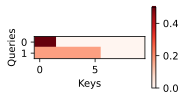

In [38]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', 
                  ylabel='Queries')

## 缩放点积注意力

要求q和k具有相同的长度d

评分函数

$
\alpha(\mathbf{q}, \mathbf{k})=\mathbf{q}^{\top} \mathbf{k} / \sqrt{d}
$

In [40]:
class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # queries的形状：(batch_size，查询的个数，d)
    # keys的形状：(batch_size，“键－值”对的个数，d)
    # values的形状：(batch_size，“键－值”对的个数，值的维度)
    # valid_lens的形状:(batch_size，)或者(batch_size，查询的个数)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # 设置transpose_b=True为了交换keys的最后两个维度
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [42]:
queries = torch.normal(0, 1, (2, 1, 2))
print('q:',queries.shape)
print('k:',keys.shape)
print('v:',values.shape)

attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

q: torch.Size([2, 1, 2])
k: torch.Size([2, 10, 2])
v: torch.Size([2, 10, 4])


tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

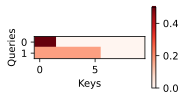

In [43]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')